# Data collection

### Experimental Setup

#### Setup
An RGB-D sensor was placed above a table facing towards it. On the table there were placed 5 on the circumference of a circle with radius 50cm. The distance of neighboring objects was 10cm. On one side of the table, the human was instructed to sit with the front of his torso tangent to the side of the table. After that, the human placed his right wrist on the center of the table.

insert image with the setup
    
#### Experiments 
In each experiment, an object (red cube) was placed in one of the five aforementioned locations. The human, having his wrist on the specified place, was instructed to approach the object in a natural way. Furthermore, he was instructed to stay still for 3 seconds before starting his movement and to stay still for 3 seconds after he reached the object.

For each location, 10 reaching motions were performed. Furthermore, we asked two users to participate in the experiments. This resulted in 100 recorded movements.

#### Data collection
The RGB-D sensor (60 Hz) was utilized for monitoring the human movements. The detection of the human and the localization of the human wrist was achieved using [OpenPose](https://github.com/CMU-Perceptual-Computing-Lab/openpose). OpenPose is an open-source 2D human pose estimation algorithm. Its output is 2D RGB pixels corresponding to human skeletal keypoints as shown in the following Figure

<div>
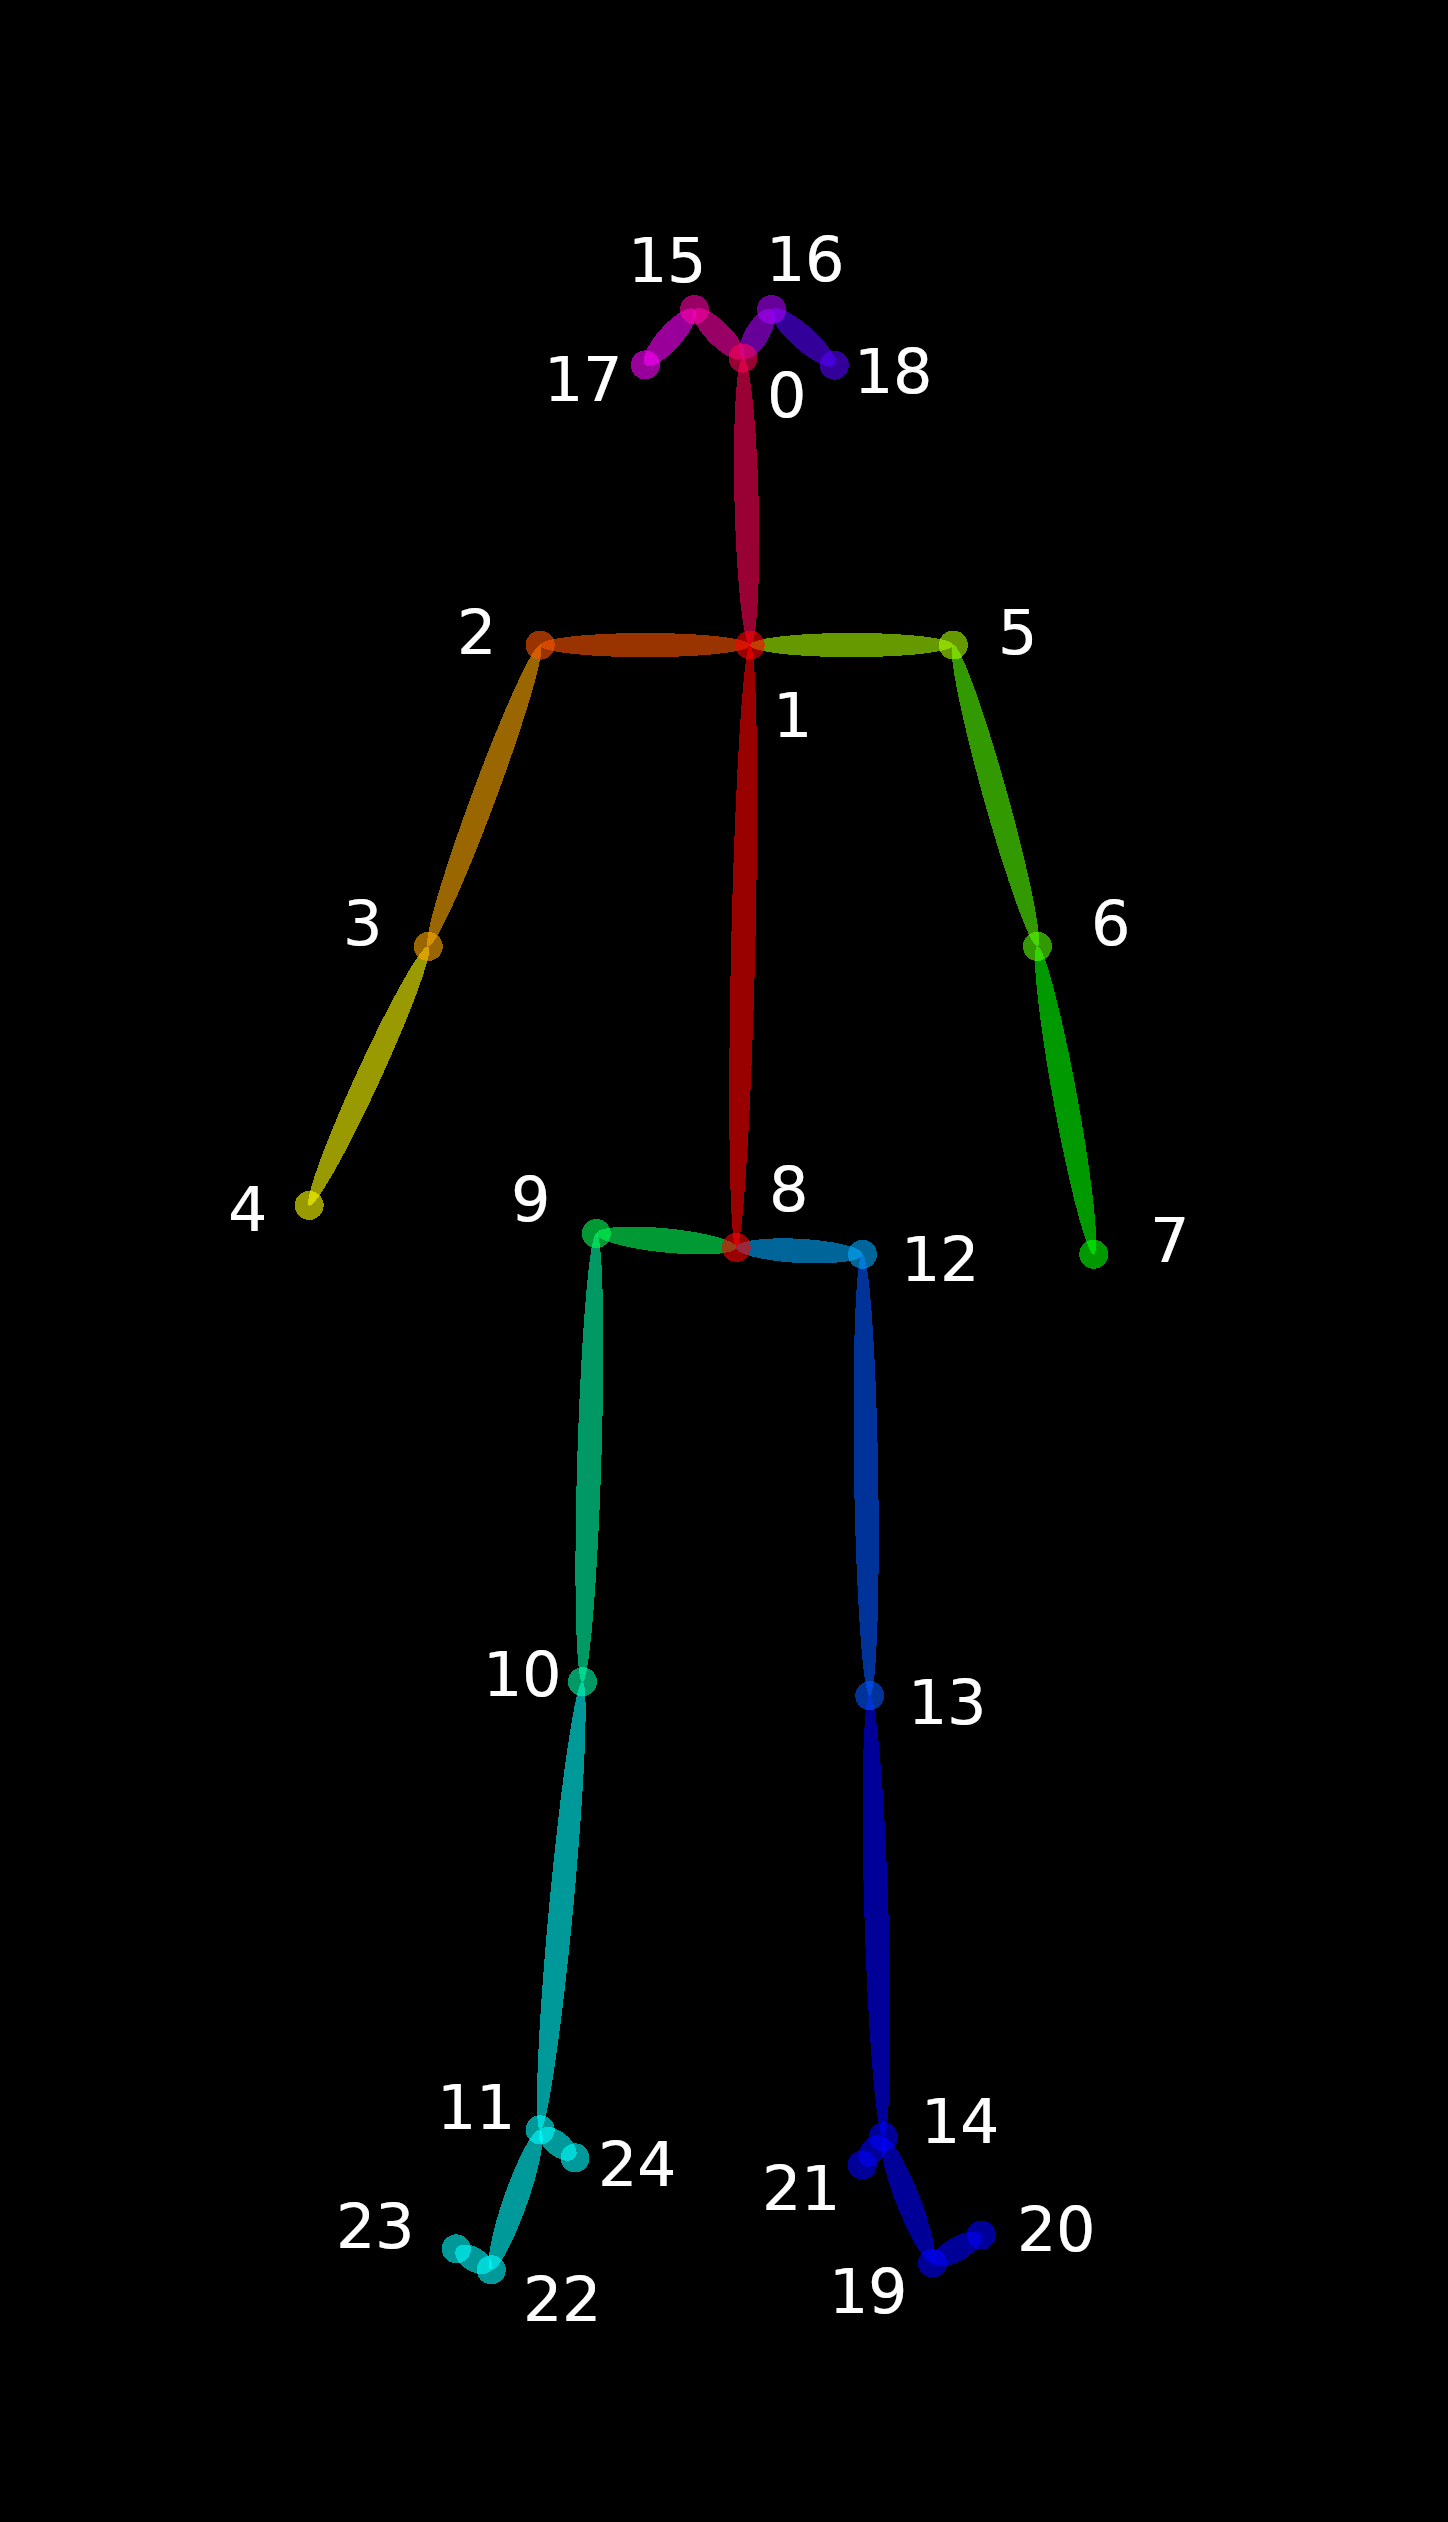
</div>

There are two ways to represent the information of the human motion. The first one is the 2D OpenPose pixels. The second one is to combine the OpenPose 2D pixels with the depth information provided by the RGB-D sensor to obtain the cartesian coordinates of the human wrist expressed in the camera frame. For this project, we collected both 2D pixels and 3D coordinates and decided to use the representation which was less noisy. For the rest of the text, <em> OpenPose points </em> correspond to 2D OpenPose pixels, while <em> Keypoints </em> correspond to 3D cartesian coordinates. 

<b> NOTE </b> Both RGB-D sensor's driver and OpenPose were integrated into [ROS](http://wiki.ros.org/Documentation) (already integrated, not part of the project) and the respective ROS wrappers were used for the acquisition of the data pertaining to the human motion. The reason was because ROS offers the possibility of associating the OpenPose output with the depth information from the RGB-D sensor in an easy way. 

Firstly, we collected the RGB frames and the respective PointCloud data, which contain the depth information. We then processed the frames using OpenPose in two ways. The first one was playing back the frames. This way we replicated a real-time behaviour of the system. The second one was to process each recorded frame one at a time. The difference is that using OpenPose imposes a processing frequency of ~22Hz, while processing each frame at a time results in information obtained at 60 Hz (camera frequency). The OpenPose frequency depends on the utilized GPU (Quadro RTX 4000 for this project). 

# Data visualization

After obtaining the data, we first visualized in the same plot the <em> OpenPose pixels </em> for one human trajectory for each object position. A second plot with the <em> Keypoints </em> of the same motions was generated as well.

<b> NOTE </b> The following plots contain the information obtained at 22 Hz (real-time frequency)

In [1]:
import pandas as pd
import numpy as np
import plotly
import plotly.offline as py
import plotly.graph_objects as go

py.init_notebook_mode(connected=True)

openpose_x, openpose_y, openpose_time = {}, {}, {}
keypoints_x, keypoints_y, keypoints_time = {}, {}, {}

def read_csv(file):
    global openpose_x, openpose_y, openpose_time 
    global keypoints_x, keypoints_y, keypoints_time 
    
    fileName = pd.read_csv(file)
    file = file.split('/')[-1].split('.')[0]

    ## Keypoints
    keypoints_time[file] = [float(str(int(item[0])) + '.' + '0'*(9-len(str(int(item[1])))) + str(int(item[1]))) \
    for item in zip(fileName['/transform_topic/keypoints/0/points/header/stamp/secs'], fileName['/transform_topic/keypoints/0/points/header/stamp/nsecs']) \
            if not np.isnan(item[0])]
    keypoints_time[file] = [i-keypoints_time[file][0] for i in keypoints_time[file]]
    keypoints_x[file] = [i for i in fileName['/transform_topic/keypoints/0/points/point/x'] if not np.isnan(i)]
    keypoints_y[file] = [i for i in fileName['/transform_topic/keypoints/0/points/point/y'] if not np.isnan(i)]
    
    ## Openpose
    openpose_time[file] = [float(str(int(item[0])) + '.' + '0'*(9-len(str(int(item[1])))) + str(int(item[1]))) \
    for item in zip(fileName['/openpose_ros/human_list/header/stamp/secs'], fileName['/openpose_ros/human_list/header/stamp/nsecs']) \
            if not np.isnan(item[0])]
    openpose_time[file] = [i-openpose_time[file][0] for i in openpose_time[file]]
    openpose_x[file] = [i for i in fileName['/openpose_ros/human_list/human_list/0/body_key_points_with_prob/4/x'] if not np.isnan(i)]
    openpose_y[file] = [i for i in fileName['/openpose_ros/human_list/human_list/0/body_key_points_with_prob/4/y'] if not np.isnan(i)]


# Runs locally
read_csv("/home/thanasis/MSC_AI/Machine_Learning/object_direction_prediction/data_collection/data/MD_pos1_01.csv")
read_csv("/home/thanasis/MSC_AI/Machine_Learning/object_direction_prediction/data_collection/data/MD_pos2_01.csv")
read_csv("/home/thanasis/MSC_AI/Machine_Learning/object_direction_prediction/data_collection/data/MD_pos3_01.csv")
read_csv("/home/thanasis/MSC_AI/Machine_Learning/object_direction_prediction/data_collection/data/MD_pos4_01.csv")
read_csv("/home/thanasis/MSC_AI/Machine_Learning/object_direction_prediction/data_collection/data/MD_pos5_01.csv")


key_idx = list(openpose_x.keys())


# Visualize Openpose pixels
fig = go.Figure(data=[go.Scatter(x=openpose_x[key_idx[i]], y=openpose_y[key_idx[i]], mode='markers', name='pos_'+str(i+1)) for i in range(5)],
               layout=go.Layout(title='OpenPose pixels',
                               xaxis=dict(title='x(pixel)', range=[150, 220]),
                               yaxis=dict(title='y(pixel)', range=[170, 100])))

py.iplot(fig)

# Visualize Keypoints coordinates
fig = go.Figure(data=[go.Scatter(x=keypoints_x[key_idx[i]], y=keypoints_y[key_idx[i]], mode='markers', name='pos_'+str(i+1)) for i in range(5)],
               layout=go.Layout(title='Keypoints',
                               xaxis=dict(title='x(m)', range=[0.1, -0.3]),
                               yaxis=dict(title='y(m)', range=[0.3, -0.15])))
py.iplot(fig)

### Results

From these two plots, it is clear that <em> OpenPose pixels </em> are less noisy than <em> Keypoints </em>. This results from the fact that <em> Keypoints </em> encapsulate the noise originated from the depth information. Therefore, for the rest project we decided to use the <b> <em> OpenPose pixels </em> </b>

<b> NOTE </b>: For a systematic evaluation of the representations, one should use the ideal human trajectory (e.g. the straight line connecting the radius of the circle with the object) and compute the standard deviation of the respective <em> OpenPose pixels </em> and the <em> Keypoints </em>. However, since the difference in the noise level was visually clear, we did not conducted further evaluation.